In [103]:
library('ggplot2')
library('reshape2')
library('ggpubr')
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
source("../../../src/tools.R")
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 250, # set the maximum number of rows displayed
        repr.matrix.max.cols = 250) # set the maximum number of columns displayed

SVM is used as an intermediary because it comes from python and then it is integrated to each feature usage datasets.

In [104]:
val_dl= c(0.7774745123223891,0.7838805490888657,0.7704904872762303,0.774985951673757,0.7695913943967247,0.7710042546359477,0.771132696475877,
         0.7696395600866982,0.762045436300875,0.7690455165770249,0.7669101709881994,0.7655294212089588,0.7763185357630248,0.783719996788954,
         0.7703459902063097,0.7745685156939873,0.7691900136469455,0.7677771534077226,0.7698803885365658,0.7694147868668219,0.762141767680822,
          0.7694950630167777,0.7667335634582966,0.7644537207995504,0.7612747852612989)

In [105]:
SVM <- read.table("prognosis_tsv/SVM_different_features_type.csv",sep=',',header=T)
SVM_final_comp <- read.table("prognosis_tsv/SVM_final_comp.csv",sep=',',header=T)
SVM <-cbind(SVM,SVM_final_comp)
#SVM[,c("eln_cyto_comp_final_comp","eln_cyto_gen_comp_final_comp","eln_clin_demo_comp_final_comp")] <- NA
list_models <- list.files('prognosis_tsv')[list.files('prognosis_tsv')!="SVM_different_features_type.csv" & list.files('prognosis_tsv')!="SVM_final_comp.csv"]
df_w_all <-NULL
for (l in list_models){
  tmp <- cbind(read.table(paste("prognosis_tsv",l,sep="/")),SVM_optimized=SVM[,substr(l,1,nchar(l)-4)])    
  tmp$model <- substr(l,1,nchar(l)-4)
  assign(substr(l,1,nchar(l)-4),melt(tmp,id='model')) 
  df_w_all <- rbind(df_w_all,get(substr(l,1,nchar(l)-4)))
}
## add dl
w <- data.frame(model=rep('all_features',25),variable=rep("deep neural network",25),value=val_dl)
df_w_all <- rbind(w,df_w_all)
colnames(df_w_all) <- c('model','algorithm','CI_test')
model_medians<-c()
df_w_all$model<-factor(df_w_all$model,levels=substr(list_models,1,nchar(list_models)-4))
for( model in levels(df_w_all$model)){

   model_medians <- c(model_medians,median(df_w_all$CI_test[df_w_all$model==as.character(model)],na.rm=T))
}
model_medians<-data.frame(model=levels(df_w_all$model),Z=model_medians)


In [124]:
tmp <- model_medians[order(model_medians$Z,decreasing=T),]
tmp[is.element(tmp$model,c('all_features','clin_demo','clin_demo_cyto','clin_demo_gen','clin_demo_comp_final_comp','clin_demo_cyto_gen','eln_clin_demo','eln_clin_demo_cyto_gen','cyto_gen','cyto_comp_final_comp','gen_comp_final_comp','cyto_gen_comp_final_comp')), ]

,model,Z
1,all_features,0.7234196
20,eln_clin_demo_cyto_gen,0.7232884
6,clin_demo_cyto_gen,0.7221100
7,clin_demo_cyto,0.7162272
8,clin_demo_gen,0.7149857
2,clin_demo_comp_final_comp,0.7142498
23,eln_clin_demo,0.7090738
9,clin_demo,0.6931245
14,cyto_gen_comp_final_comp,0.6525043
16,cyto_gen,0.6508146


##### Conclusion: Clinical and demographical are the more important features for the prognosis models.
##### The eln is also an important parameter because it is solo and it definitely imporves prognosis

##### Of course adding genetical and cytogenetical data slightly improve the overallsurvival prognosis.
##### Adding genetical information or cytogenetical information of component information has the same effect on prognosis when we have clinical and demographical features used for evaluation.

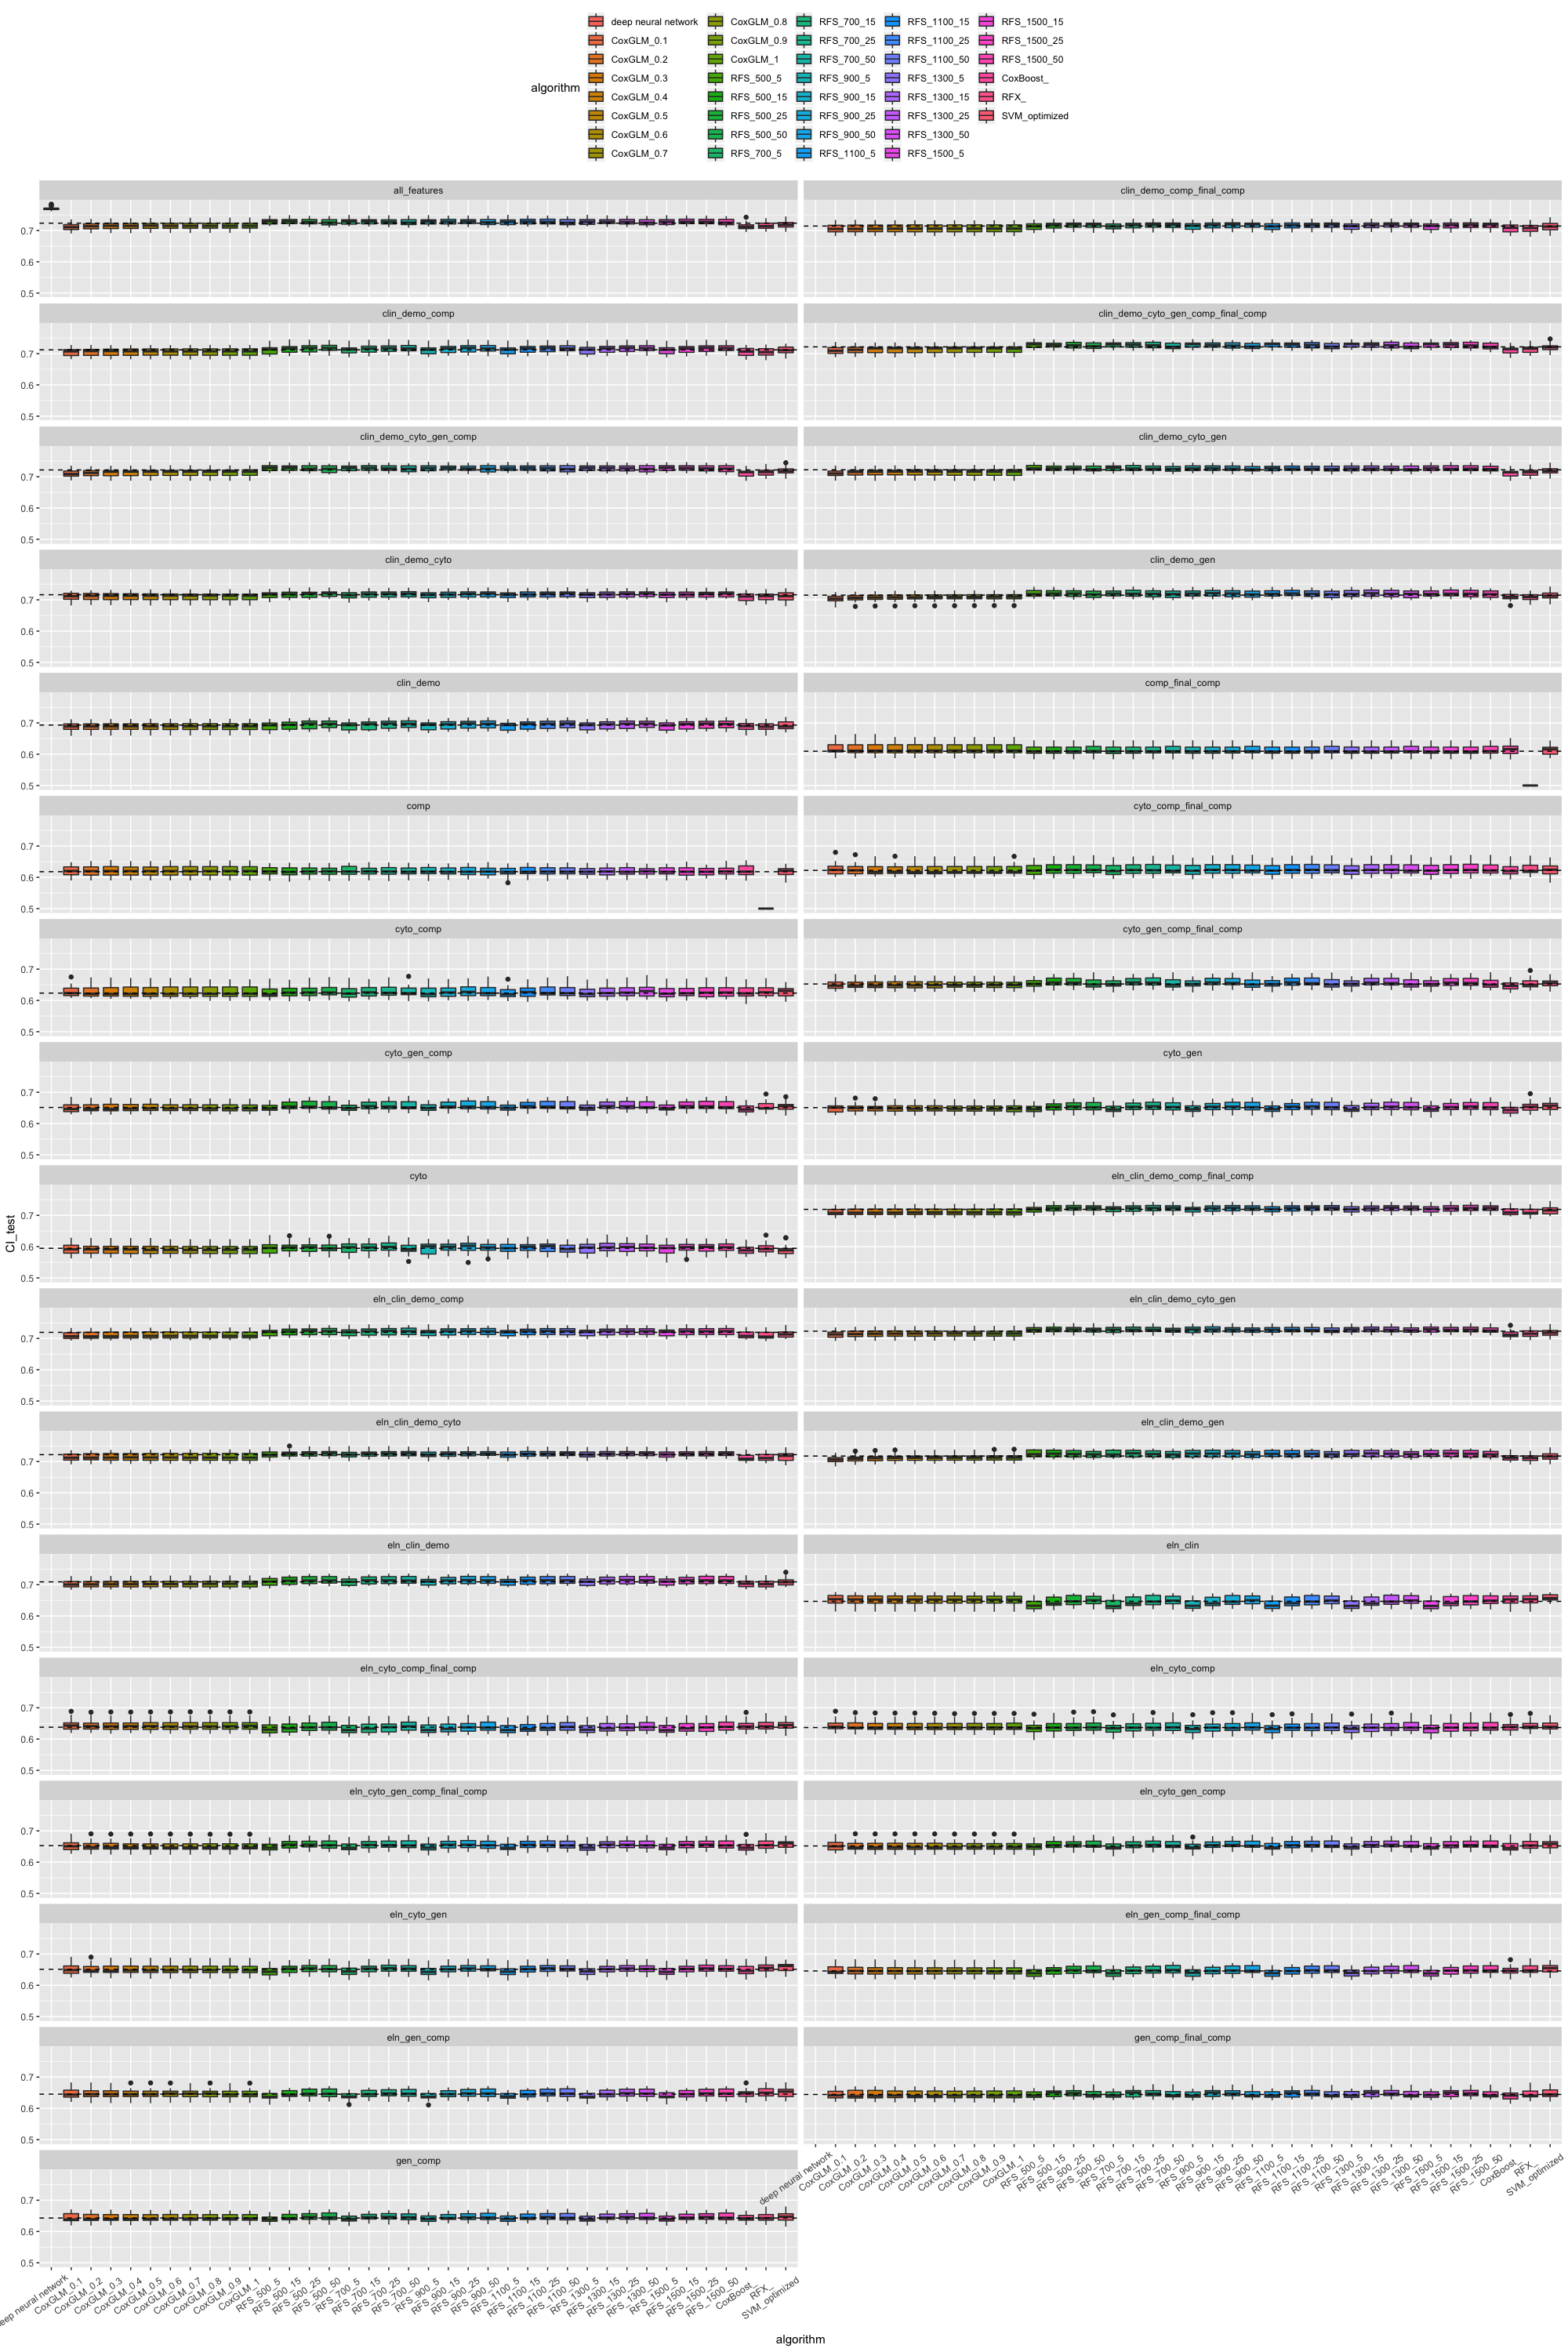

In [58]:
set_notebook_plot_size(20,30)
ggplot(df_w_all,aes(x=algorithm,y=CI_test)) +
    geom_boxplot(aes(fill = algorithm), notch=F)+
    #scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
    facet_wrap( ~ model, ncol=2) +
    geom_hline(data = model_medians, aes(yintercept = Z), linetype = 2)+
    theme(legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) 

In [16]:
### Model Performance visualization with Deep Neural Net

In [59]:
#nrow = number of prognosis models 
#ncol = number of feature models
table_res <- as.data.frame(matrix(0,nrow =38, ncol=33))
colnames(table_res)<-levels(df_w_all$model)
rownames(table_res)<-levels(df_w_all$algorithm)

for(model in colnames(table_res)){
    for(algo in rownames(table_res)){
        table_res[algo,model]<-median(df_w_all$CI_test[df_w_all$model==model & df_w_all$algorithm==algo])
    }
}
row_names <-rownames(table_res)
table_res$algo<-rownames(table_res)
rownames(table_res)<-NULL
table_res<-melt(table_res,id='algo')
colnames(table_res)<-c('algo','model','CI_test')
table_res$algo<-factor(table_res$algo,levels=row_names)
table_res$model<-factor(table_res$model)

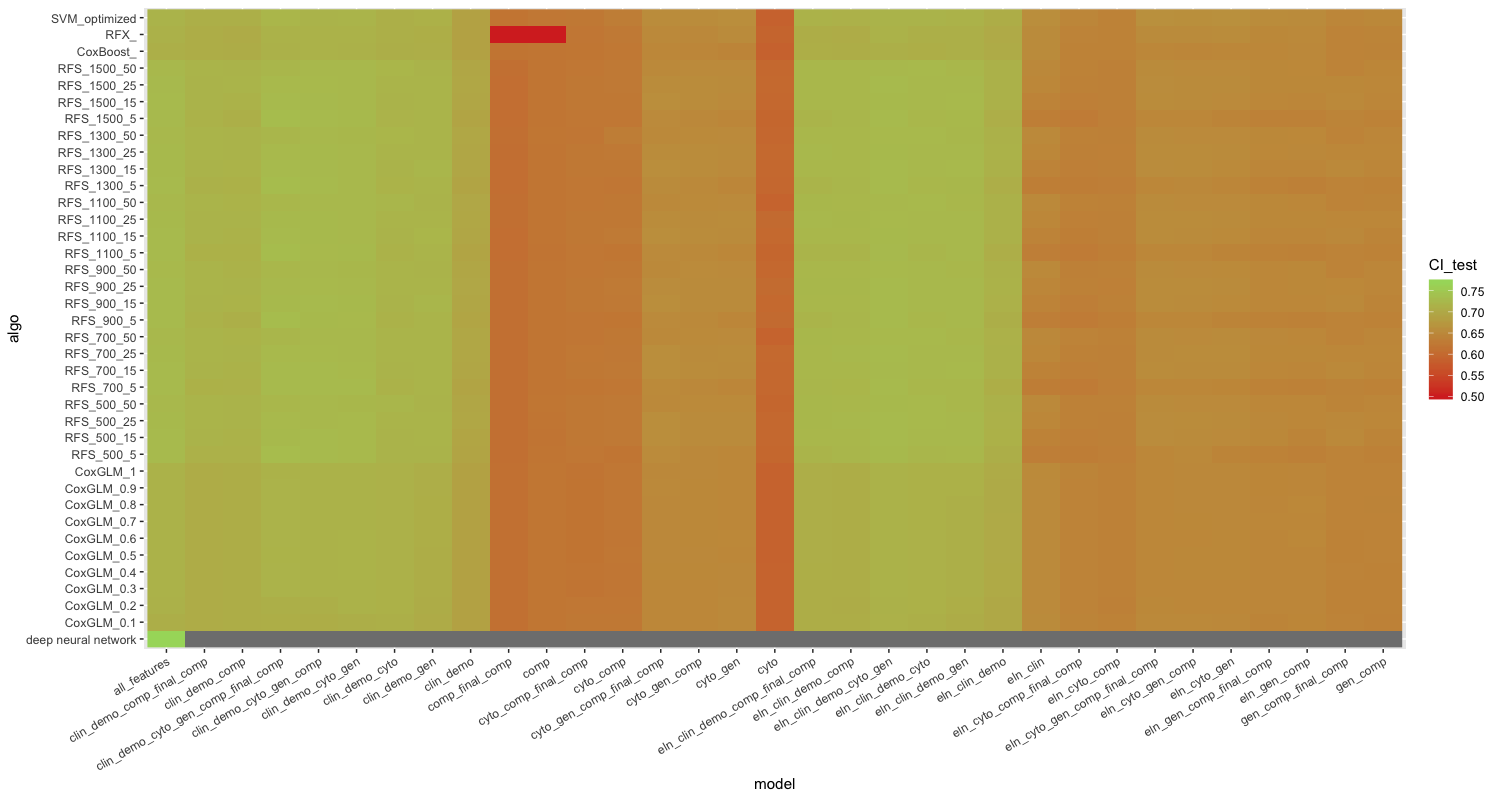

In [60]:
set_notebook_plot_size(15,8)
ggplot(table_res, aes(model, algo)) +

    # geom raster heatmap
    geom_raster(aes(fill = CI_test), show.legend = TRUE) +
    scale_fill_gradient(low="#d73027", high="#a6d96a") +
    tilt_x_label(30) 

In [ ]:
#nrow = number of prognosis models 
#ncol = number of feature models
table_res <- as.data.frame(matrix(0,nrow =37, ncol=23))
colnames(table_res)<-levels(df_w_all$model)
rownames(table_res)<-levels(df_w_all$algorithm)

for(model in colnames(table_res)){
    for(algo in rownames(table_res)){
        table_res[algo,model]<-median(df_w_all$CI_test[df_w_all$model==model & df_w_all$algorithm==algo])
    }
}
row_names <-rownames(table_res)
table_res$algo<-rownames(table_res)
rownames(table_res)<-NULL
table_res<-melt(table_res,id='algo')
colnames(table_res)<-c('algo','model','CI_test')
table_res$algo<-factor(table_res$algo,levels=row_names)
table_res$model<-factor(table_res$model)

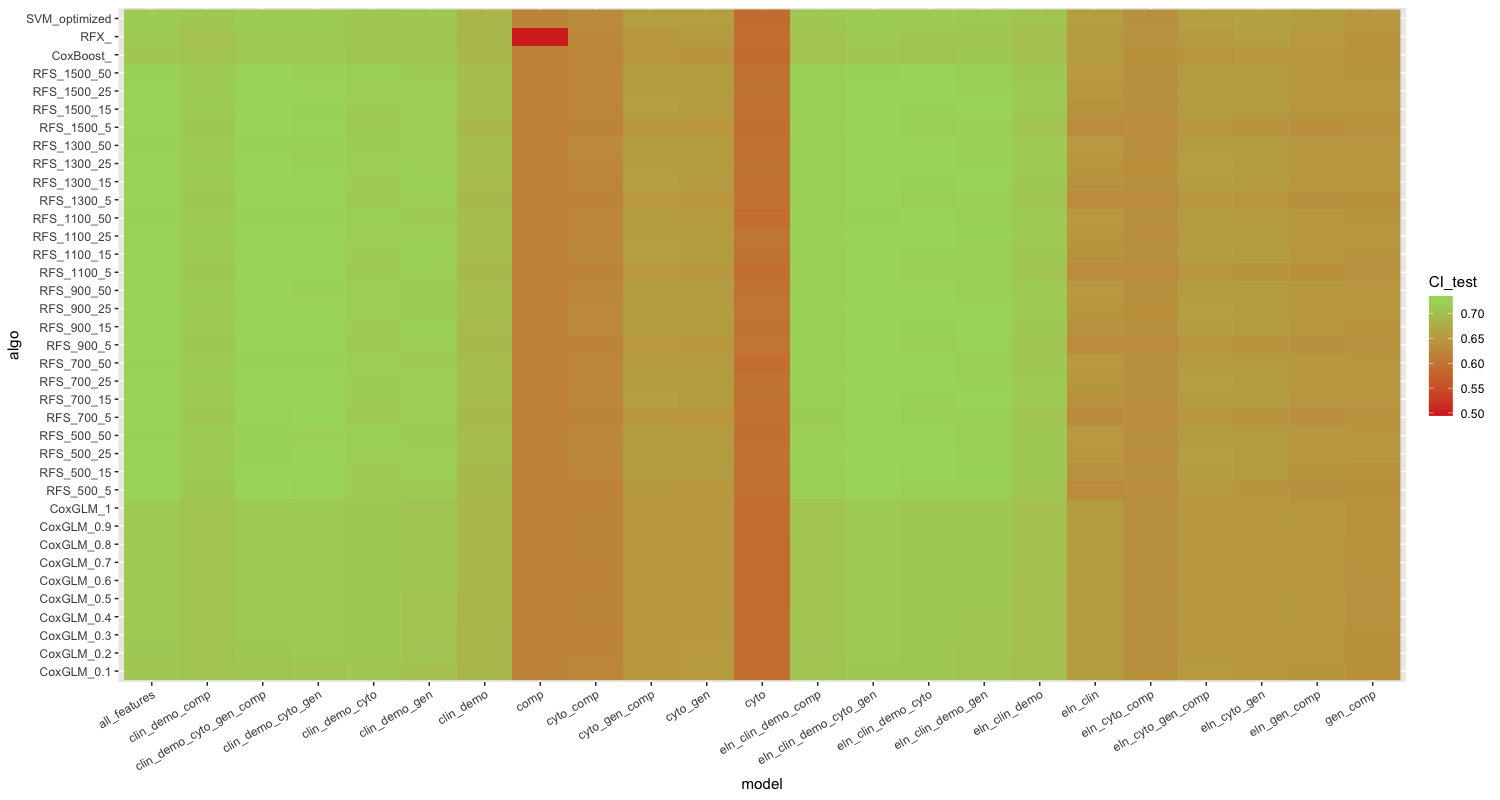

In [17]:
set_notebook_plot_size(15,8)
ggplot(table_res, aes(model, algo)) +

    # geom raster heatmap
    geom_raster(aes(fill = CI_test), show.legend = TRUE) +
    scale_fill_gradient(low="#d73027", high="#a6d96a") +
    tilt_x_label(30) 

# Evaluation of feature importance for different models 

In [3]:
df_final <- read.table("df_prognosis_features_ready.tsv",sep = '\t' , header = T)
### Features that we can use
all_features <- c(1:177)
eln_clin<-c(1,169:175)
eln_clin_demo<-c(1,169:177)
eln_clin_demo_cyto <-c(1,85:153,169:177)
eln_clin_demo_gen <-c(1:84,169:177)
eln_clin_demo_cyto_gen <-c(1:153,169:177)
eln_clin_demo_comp <-c(1,154:177)
eln_cyto_gen<-c(1:153)
eln_cyto_gen_comp <-c(1:168)
eln_cyto_comp <-c(1,85:168)
eln_gen_comp <-c(1:84,154:168)

clin_demo<-c(169:177)
clin_demo_cyto <-c(85:153,169:177)
clin_demo_gen <-c(2:84,169:177)
clin_demo_cyto_gen <-c(2:153,169:177)
clin_demo_comp <-c(154:177)
cyto_gen<-c(2:153)
cyto_gen_comp <-c(2:168)
cyto_comp <-c(85:168)
gen_comp <-c(2:84,154:168)
clin_demo_cyto_gen_comp<-c(2:177)
gen<-c(2:84)
cyto<-c(85:153)
comp<-c(154:168)
###
x <- data.matrix(df_final)
y <- data.matrix(df_final[,c("os","os_status")])

colnames(y) = c("time","status")
response=y
design=x[,all_features]
nrepeats=5
nfolds=5
set.seed(17)
# Make folds

n = nrow(design)
folds <- list()
for (i in seq(nrepeats)) {
    folds <- c(folds,split(sample(seq(n)), rep(1:nfolds, length = n)))
}
nexp = length(folds) # the total number CV of experiments


# I- Cox Models with Penalization

In [11]:
# Chose features you want with design
design=x[,all_features]
# Parallel CV
print("start CV")
rescv = mclapply(seq(nexp),
               FUN=function(iexp) {
                   set.seed(17)
                   cat(".")
                   vTrain = design[-folds[[iexp]],,drop=F]
                   vTest = design[folds[[iexp]],,drop=F]
                   lTrain = response[-folds[[iexp]],]
                   lTest = response[folds[[iexp]],]
                   # Train and Predict
                   cvfit = cv.glmnet(vTrain, lTrain, family="cox", alpha=0.1, nfolds=10, grouped=TRUE)
                   risk.predict = predict(cvfit, newx=vTest, s="lambda.min", type="response")
                   risk.predict = as.vector(risk.predict[,1])
                   ci.test = suppressWarnings(survConcordance(Surv(time,status) ~ risk.predict, as.data.frame(lTest)))
                   # Evaluate CI on the test
                   #return(as.vector(coef(cvfit,s="lambda.min")))
                   return(list(as.matrix(coef(cvfit,s="lambda.min")),as.vector(ci.test$concordance)))  ## return a list with dataframe for variable importance and concordance index of the exp
               },
               mc.cores=25
               )


[1] "start CV"


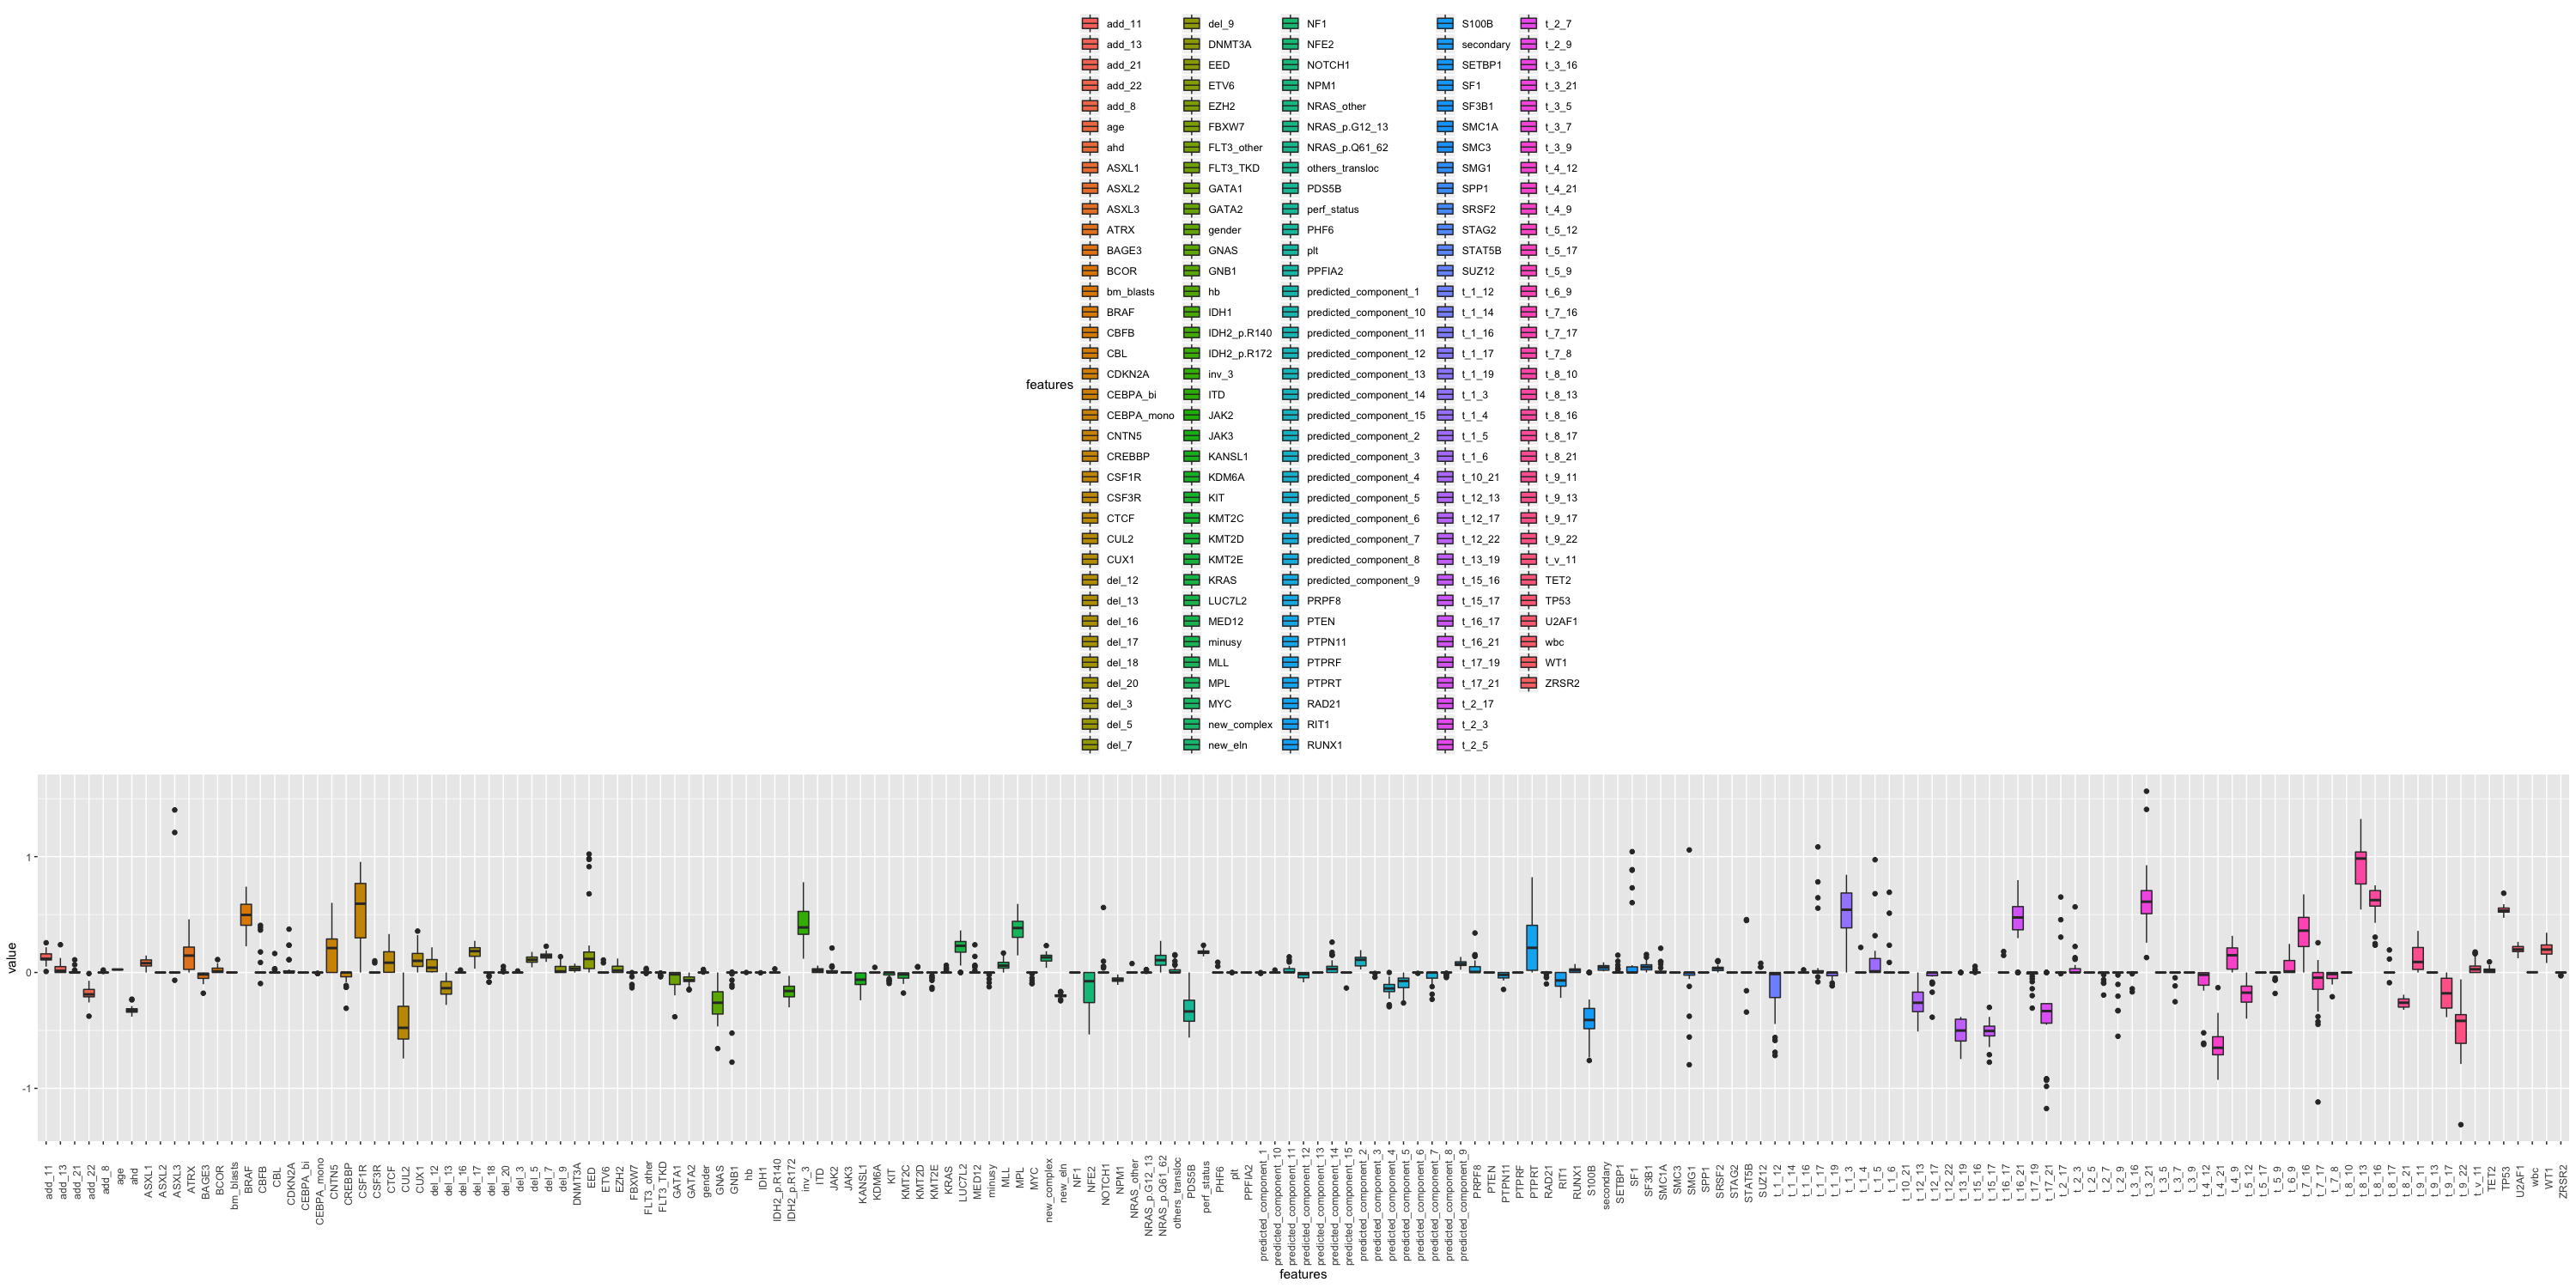

In [12]:
### rescv returns a list with 25 dataframes with the coefficient of each variables for the model cross validated fitted model and 25 concordance indices on the testings set used . We do the boxplots of the variable
### importance to have an exhaustive view over the same algorithm trained differently.
tmp <- rescv[[1]][[1]]
colnames(tmp)[1] <- "exp_1"
for (i in 2:length(rescv)){
    tmp <-cbind(tmp,rescv[[i]][[1]])
    colnames(tmp)[i] <- paste("exp",i,sep="_")
}
tmp <-as.data.frame(tmp)
tmp$median <- apply(tmp,1, median, na.rm = TRUE)
tmp$features <-rownames(tmp)
b <-melt(tmp,id='features')
colnames(b) <- c('features','exp','value')
set_notebook_plot_size(30,15)
ggplot(b,aes(x=features,y=value)) +
    geom_boxplot(aes(fill = features), notch=F)+
    #scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
    #facet_wrap( ~ model, ncol=2) +
    #geom_hline(data = model_medians, aes(yintercept = Z), linetype = 2)+
    theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))

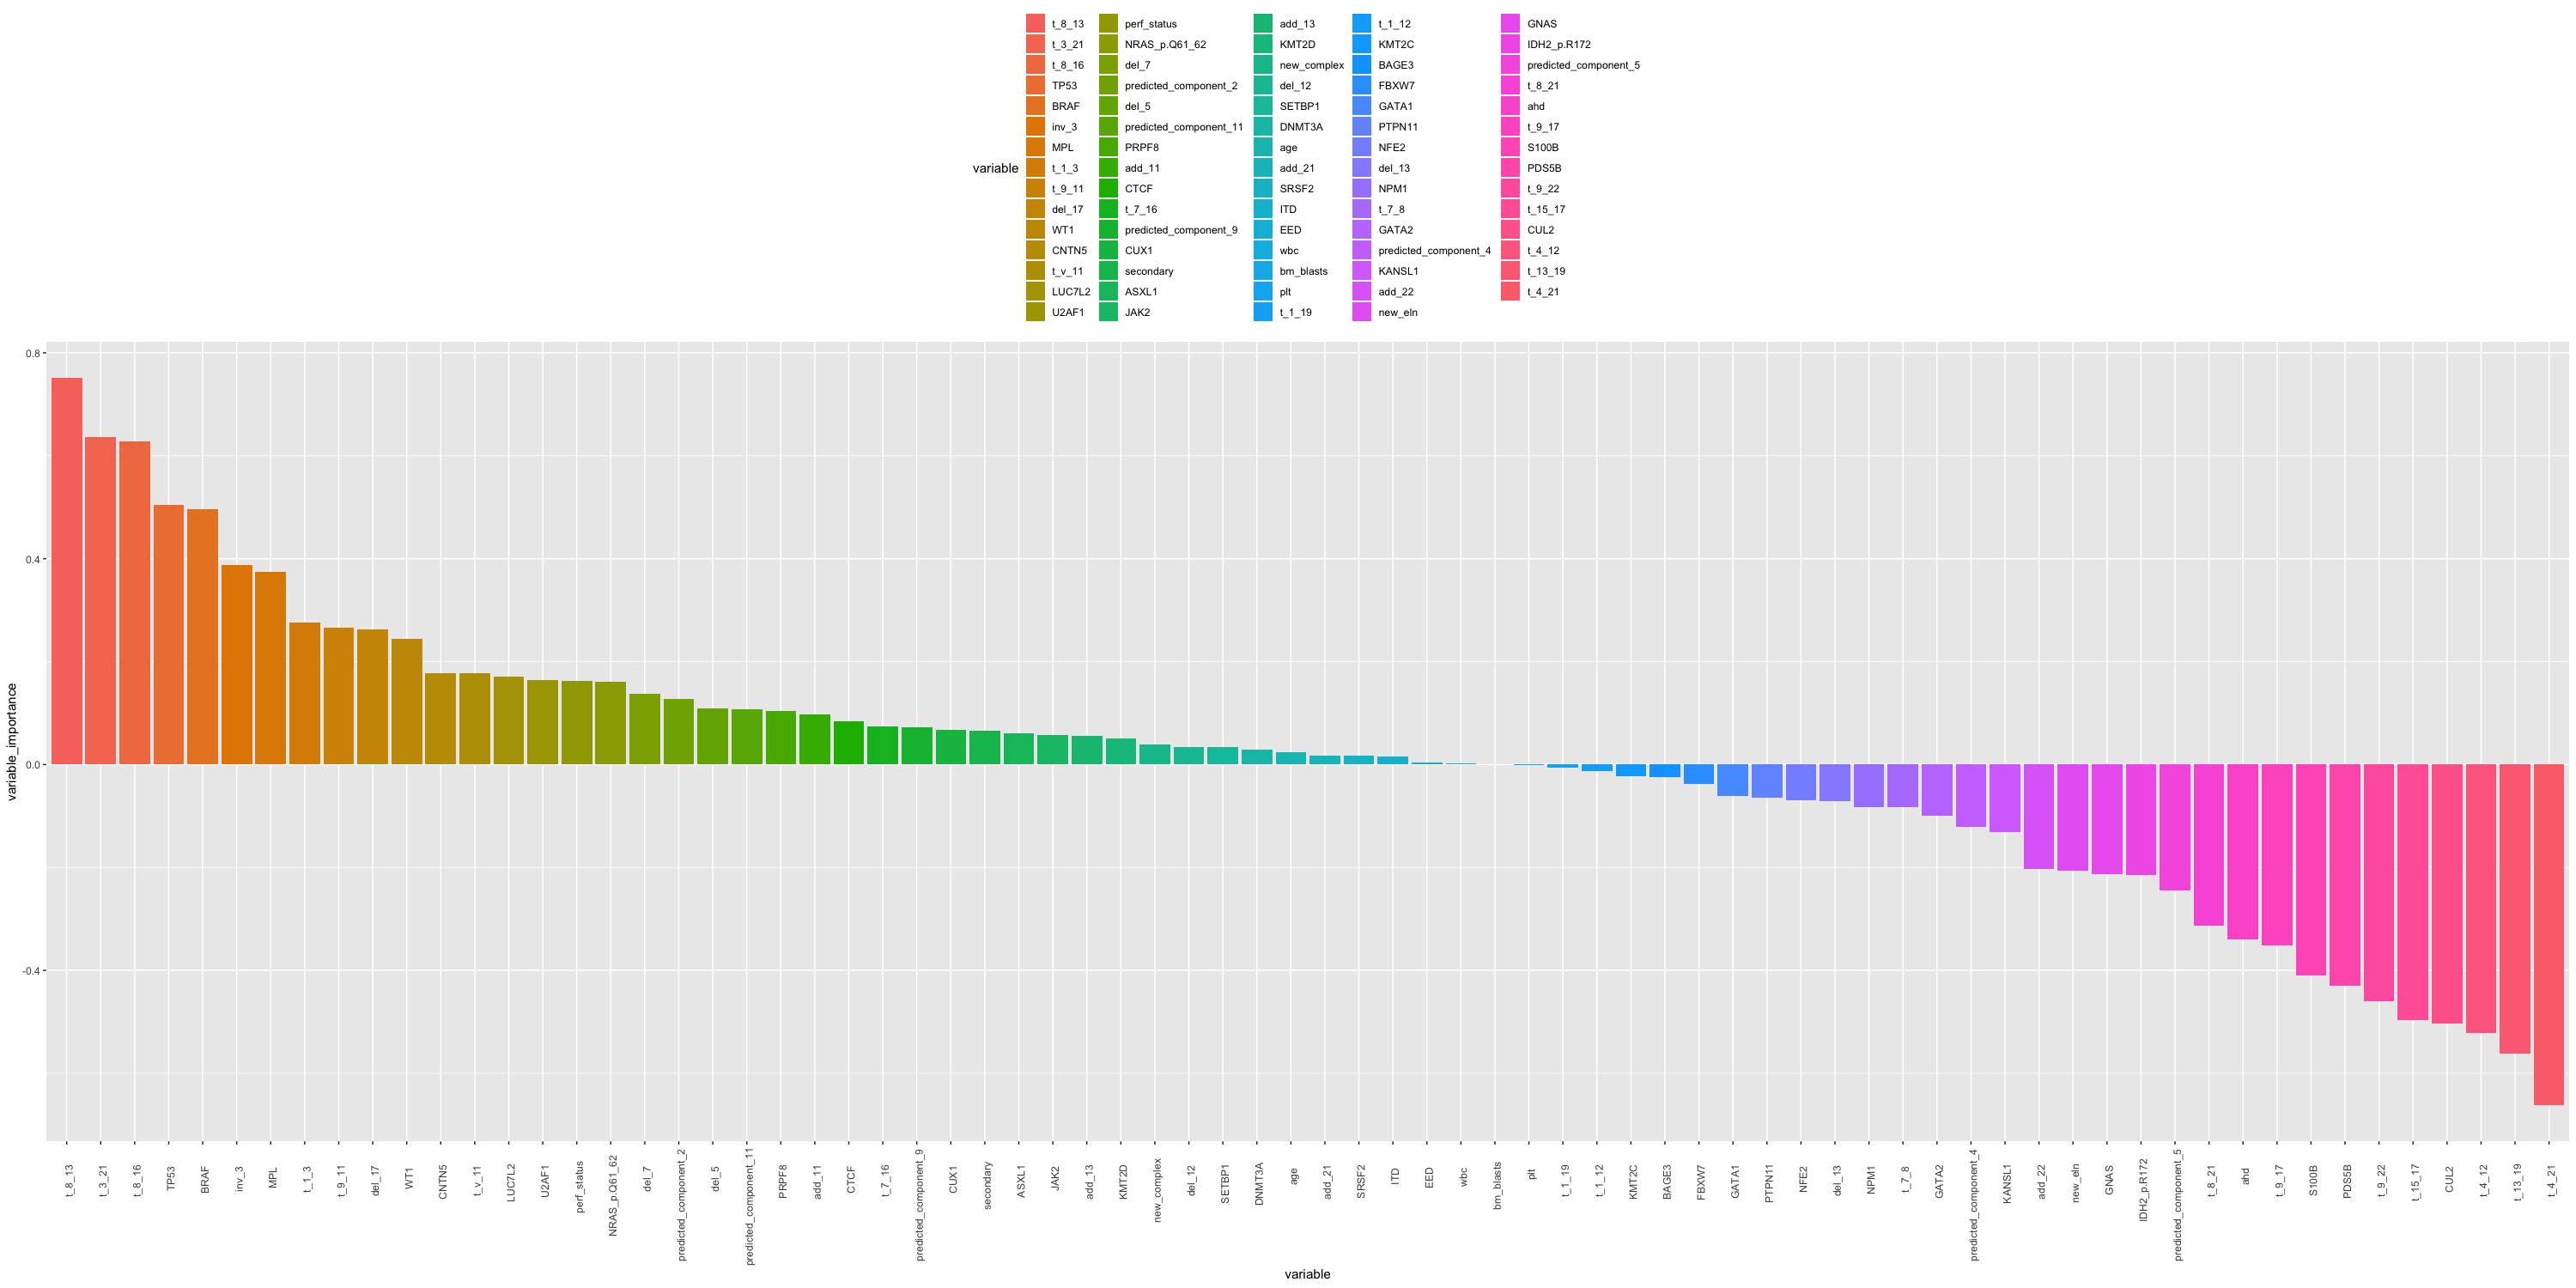

In [13]:
##Here, we look at the best concordance index that we got on testing set and we look at the coefficient that were obtained.
max_ci <-vector()
for (i in 1:length(rescv)){
    max_ci <- append(max_ci,rescv[[i]][[2]])
}

max = which(max_ci==max(max_ci))
l<- rescv[[max]][[1]]
l <- data.frame(l[l != 0,])
colnames(l) <- "variable_importance"
l$variable <-rownames(l)
l <- l[order(l$variable_importance,decreasing=T),]
l$variable <- factor(l$variable, levels = l$variable)

ggplot(l, aes(x=variable,y=variable_importance,fill=variable))+geom_bar(stat='identity')+
theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))

# II- Random Forest Variable Importance

In [65]:
# Chose features you want with design
design=x[,all_features]
# Parallel CV
print("start CV")
rescv = mclapply(seq(nexp),
               FUN=function(iexp) {
                   set.seed(17)
                   cat(".")
                   vTrain = design[-folds[[iexp]],,drop=F]
                   vTest = design[folds[[iexp]],,drop=F]
                   lTrain = response[-folds[[iexp]],]
                   lTest = response[folds[[iexp]],]
                   # Train and Predict
                   #cvfit = cv.glmnet(vTrain, lTrain, family="cox", alpha=0.1, nfolds=10, grouped=TRUE)
                   cvfit = rfsrc(Surv(time, status) ~ ., data=data.frame(vTrain,lTrain), ntree=1500, importance="TRUE",nodesize=15)
    
                    # Predict
                   risk.predict = predict(cvfit, data.frame(vTest), importance="TRUE")$predicted
                   ci.test = suppressWarnings(survConcordance(Surv(time,status) ~ risk.predict, as.data.frame(lTest)))
                   # Evaluate CI on the test
                   #return(as.vector(coef(cvfit,s="lambda.min")))
                   #return (as.vector(ci.test$concordance))
                   return(list(as.matrix(cvfit$importance),as.vector(ci.test$concordance)))  ## return a list with dataframe for variable importance and concordance index of the exp
               },
               mc.cores=50
               )

[1] "start CV"


In [ ]:
### rescv returns a list with 25 dataframes with the coefficient of each variables for the model cross validated fitted model and 25 concordance indices on the testings set used . We do the boxplots of the variable
### importance to have an exhaustive view over the same algorithm trained differently.
tmp <- rescv[[1]][[1]]
colnames(tmp)[1] <- "exp_1"
for (i in 2:length(rescv)){
    tmp <-cbind(tmp,rescv[[i]][[1]])
    colnames(tmp)[i] <- paste("exp",i,sep="_")
}
tmp <-as.data.frame(tmp)
tmp$median <- apply(tmp,1, median, na.rm = TRUE)
tmp$features <-rownames(tmp)
b <-melt(tmp,id='features')
colnames(b) <- c('features','exp','value')
set_notebook_plot_size(30,15)
ggplot(b,aes(x=features,y=value)) +
    geom_boxplot(aes(fill = features), notch=F)+
    #scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
    #facet_wrap( ~ model, ncol=2) +
    #geom_hline(data = model_medians, aes(yintercept = Z), linetype = 2)+
    theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))

In [ ]:
##Here, we look at the best concordance index that we got on testing set and we look at the coefficient that were obtained.
set_notebook_plot_size(20,12)
max_ci <-vector()
for (i in 1:length(rescv)){
    max_ci <- append(max_ci,rescv[[i]][[2]])
}
max = which(max_ci==max(max_ci))
l<- rescv[[max]][[1]]
l <- data.frame(l[l != 0,])
colnames(l) <- "variable_importance"
l$variable <-rownames(l)
l <- l[order(l$variable_importance,decreasing=T),]
l$variable <- factor(l$variable, levels = l$variable)

ggplot(l, aes(x=variable,y=variable_importance,fill=variable))+geom_bar(stat='identity')+
theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))

<img src="https://files.slack.com/files-pri/T09AZSFNJ-FJFDTDY1Z/screen_shot_2019-05-17_at_11.43.33_am.png">

##### Interesting to see that age is selected as the most important feature for the random forest

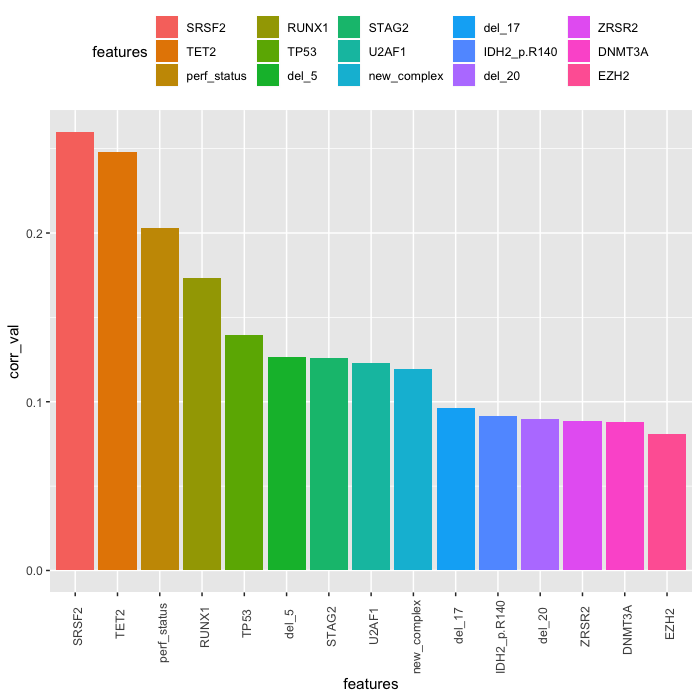

In [111]:

corr <- cor(design[,colnames(design)!='age'],design[,'age'])
corr <-data.frame(corr_val=corr[order(corr,decreasing=T),][c(1,2,5:11,14:19)])
corr$features <-factor(rownames(corr),levels=rownames(corr))
ggplot(corr,aes(x=features,y=corr_val))+geom_bar(stat = "identity", aes(fill = features))+
theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))

# III Boosting Feature Importance 

In [14]:
# Chose features you want with design
design=x[,all_features]
# Parallel CV
print("start CV")
rescv = mclapply(seq(nexp),
               FUN=function(iexp) {
                   set.seed(17)
                   cat(".")
                   vTrain = design[-folds[[iexp]],,drop=F]
                   vTest = design[folds[[iexp]],,drop=F]
                   lTrain = response[-folds[[iexp]],]
                   lTest = response[folds[[iexp]],]
                   # Train and Predict
                   #cvfit = cv.glmnet(vTrain, lTrain, family="cox", alpha=0.1, nfolds=10, grouped=TRUE)
                   #cvfit = rfsrc(Surv(time, status) ~ ., data=data.frame(vTrain,lTrain), ntree=1500, importance="TRUE",nodesize=15)
                   cvfit<-CoxBoost(time=lTrain[,1],status=lTrain[,2],x=vTrain)
                   risk.predict<-as.vector(predict(cvfit,vTest,newtime=lTest[,1],newstatus=lTest[,2],type='lp'))
                   ci.test = suppressWarnings(survConcordance(Surv(time,status) ~ risk.predict, as.data.frame(lTest)))
                   return(list(as.matrix(coefficients(cvfit)),as.vector(ci.test$concordance)))  ## return a list with dataframe for variable importance and concordance index of the exp
               },
               mc.cores=25
               )

[1] "start CV"


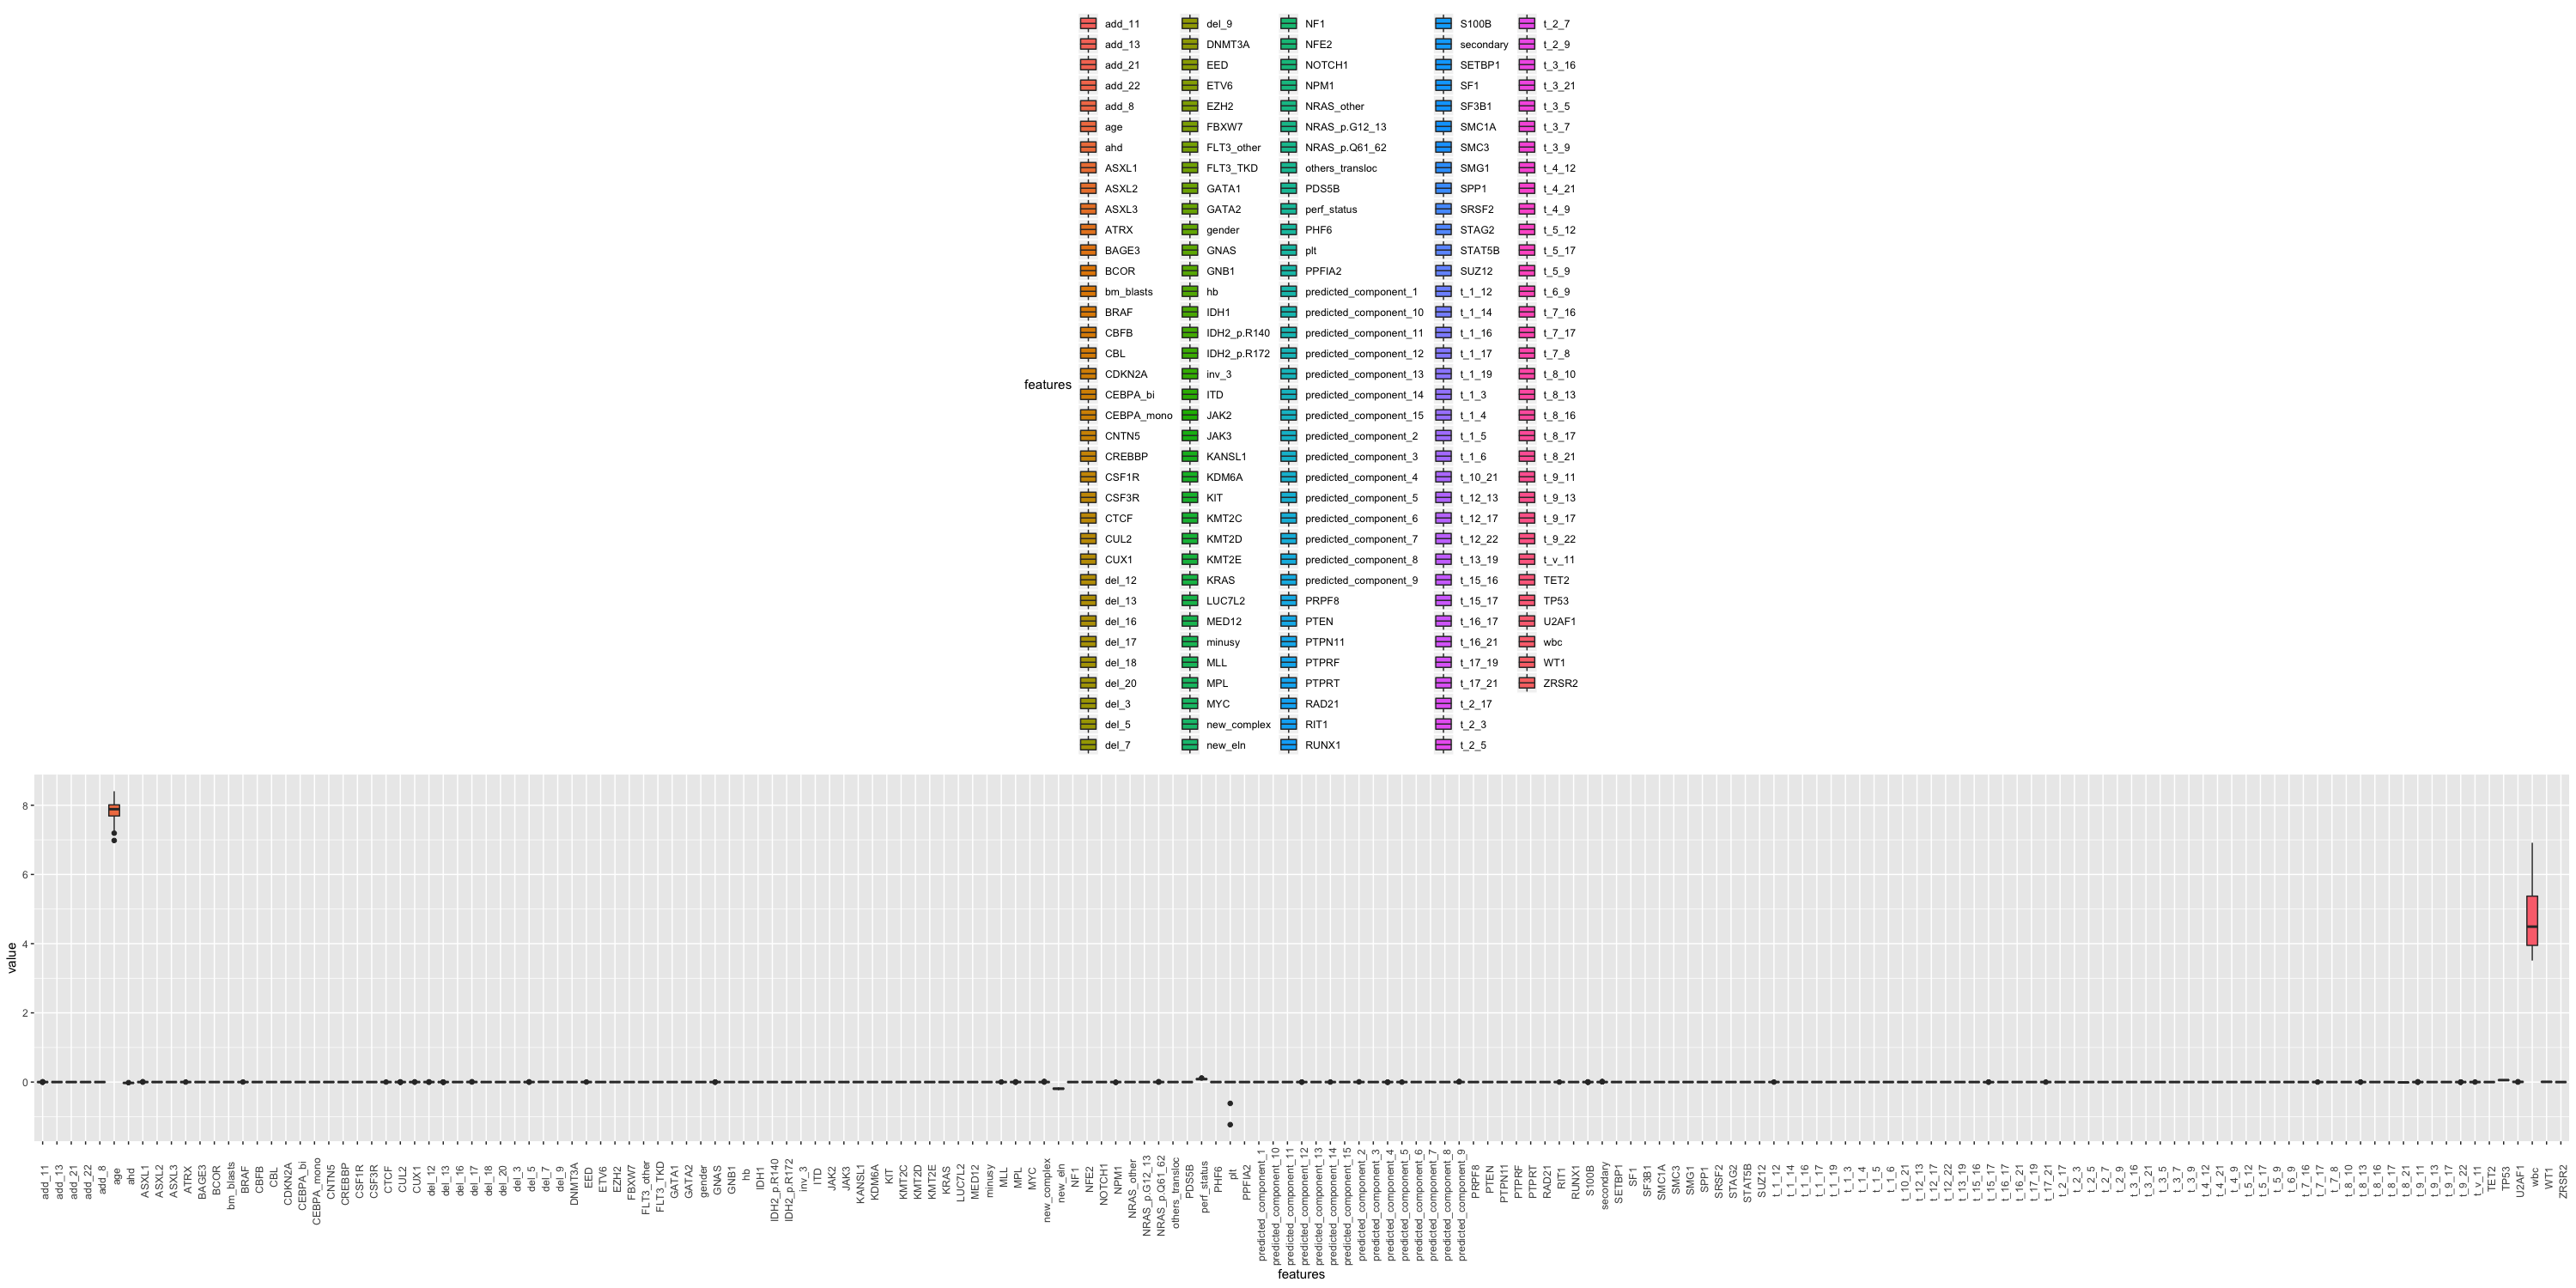

In [15]:
### rescv returns a list with 25 dataframes with the coefficient of each variables for the model cross validated fitted model and 25 concordance indices on the testings set used . We do the boxplots of the variable
### importance to have an exhaustive view over the same algorithm trained differently.
tmp <- rescv[[1]][[1]]
colnames(tmp)[1] <- "exp_1"
for (i in 2:length(rescv)){
    tmp <-cbind(tmp,rescv[[i]][[1]])
    colnames(tmp)[i] <- paste("exp",i,sep="_")
}
tmp <-as.data.frame(tmp)
tmp$median <- apply(tmp,1, median, na.rm = TRUE)
tmp$features <-rownames(tmp)
b <-melt(tmp,id='features')
colnames(b) <- c('features','exp','value')
set_notebook_plot_size(30,15)
ggplot(b,aes(x=features,y=value)) +
    geom_boxplot(aes(fill = features), notch=F)+
    #scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
    #facet_wrap( ~ model, ncol=2) +
    #geom_hline(data = model_medians, aes(yintercept = Z), linetype = 2)+
    theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))

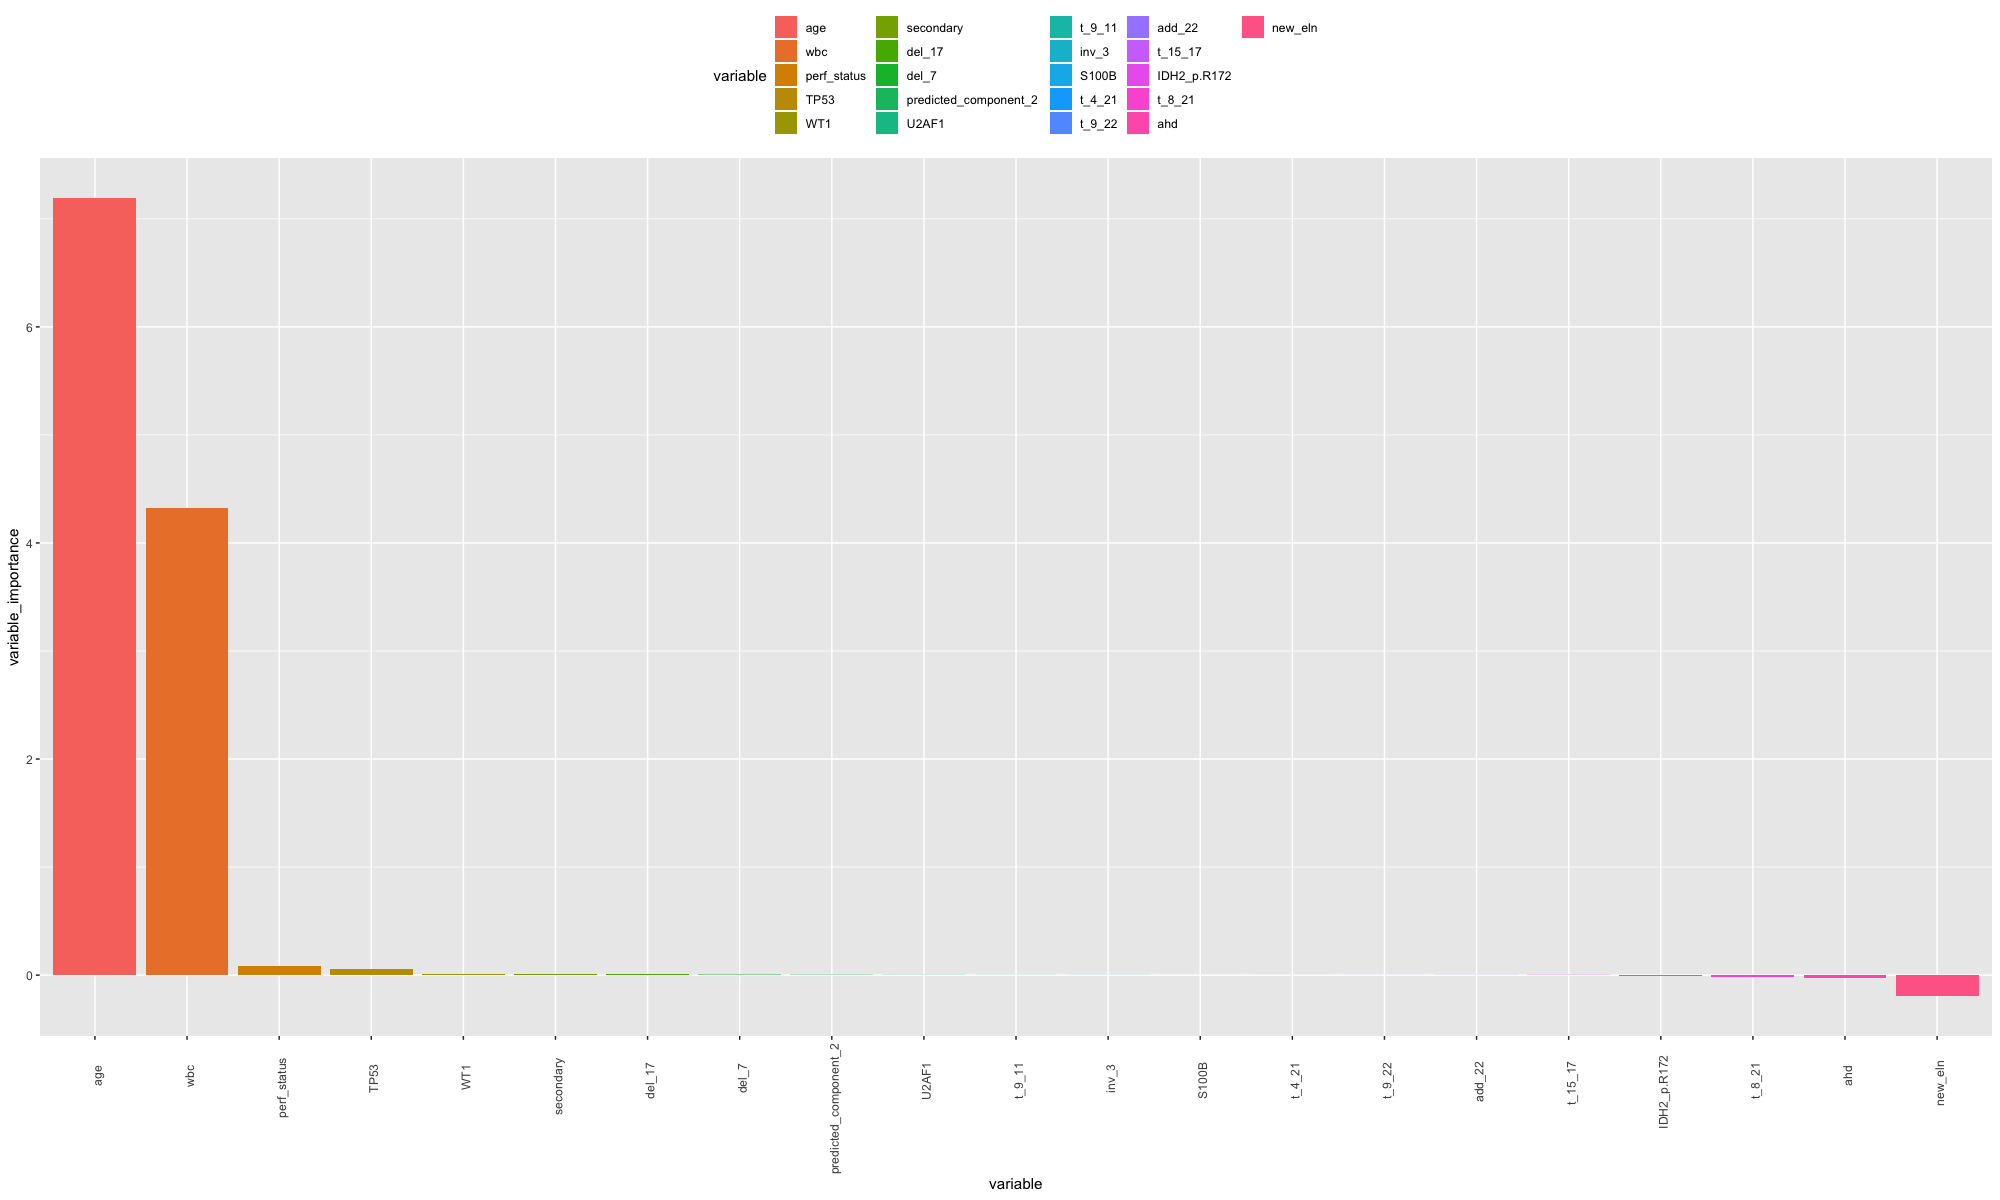

In [16]:
##Here, we look at the best concordance index that we got on testing set and we look at the coefficient that were obtained.
set_notebook_plot_size(20,12)
max_ci <-vector()
for (i in 1:length(rescv)){
    max_ci <- append(max_ci,rescv[[i]][[2]])
}
max = which(max_ci==max(max_ci))
l<- rescv[[max]][[1]]
l <- data.frame(l[l != 0,])
colnames(l) <- "variable_importance"
l$variable <-rownames(l)
l <- l[order(l$variable_importance,decreasing=T),]
l$variable <- factor(l$variable, levels = l$variable)

ggplot(l, aes(x=variable,y=variable_importance,fill=variable))+geom_bar(stat='identity')+
theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))

# IV Random Effects

In [17]:
# Chose features you want with design
design=x[,all_features]
# Parallel CV
print("start CV")
rescv = mclapply(seq(nexp),
               FUN=function(iexp) {
                   set.seed(17)
                   cat(".")
                   vTrain = design[-folds[[iexp]],,drop=F]
                   vTest = design[folds[[iexp]],,drop=F]
                   lTrain = response[-folds[[iexp]],]
                   lTest = response[folds[[iexp]],]
                   # Train and Predict
                   #cvfit = cv.glmnet(vTrain, lTrain, family="cox", alpha=0.1, nfolds=10, grouped=TRUE)
                   #cvfit = rfsrc(Surv(time, status) ~ ., data=data.frame(vTrain,lTrain), ntree=1500, importance="TRUE",nodesize=15)
                   cvfit<-CoxRFX(data.frame(vTrain),Surv(time=lTrain[,1],event =lTrain[,2]) , max.iter =50,tol=1e-3)
                   cvfit$Z <- NULL
                   # Predict
                   risk.predict<-predict(cvfit,data.frame(vTest))
                   ci.test = suppressWarnings(survConcordance(Surv(time,status) ~ risk.predict, as.data.frame(lTest)))
                   return(list(as.matrix(coef(cvfit)),as.vector(ci.test$concordance)))  ## return a list with dataframe for variable importance and concordance index of the exp
               },
               mc.cores=25
               )

[1] "start CV"


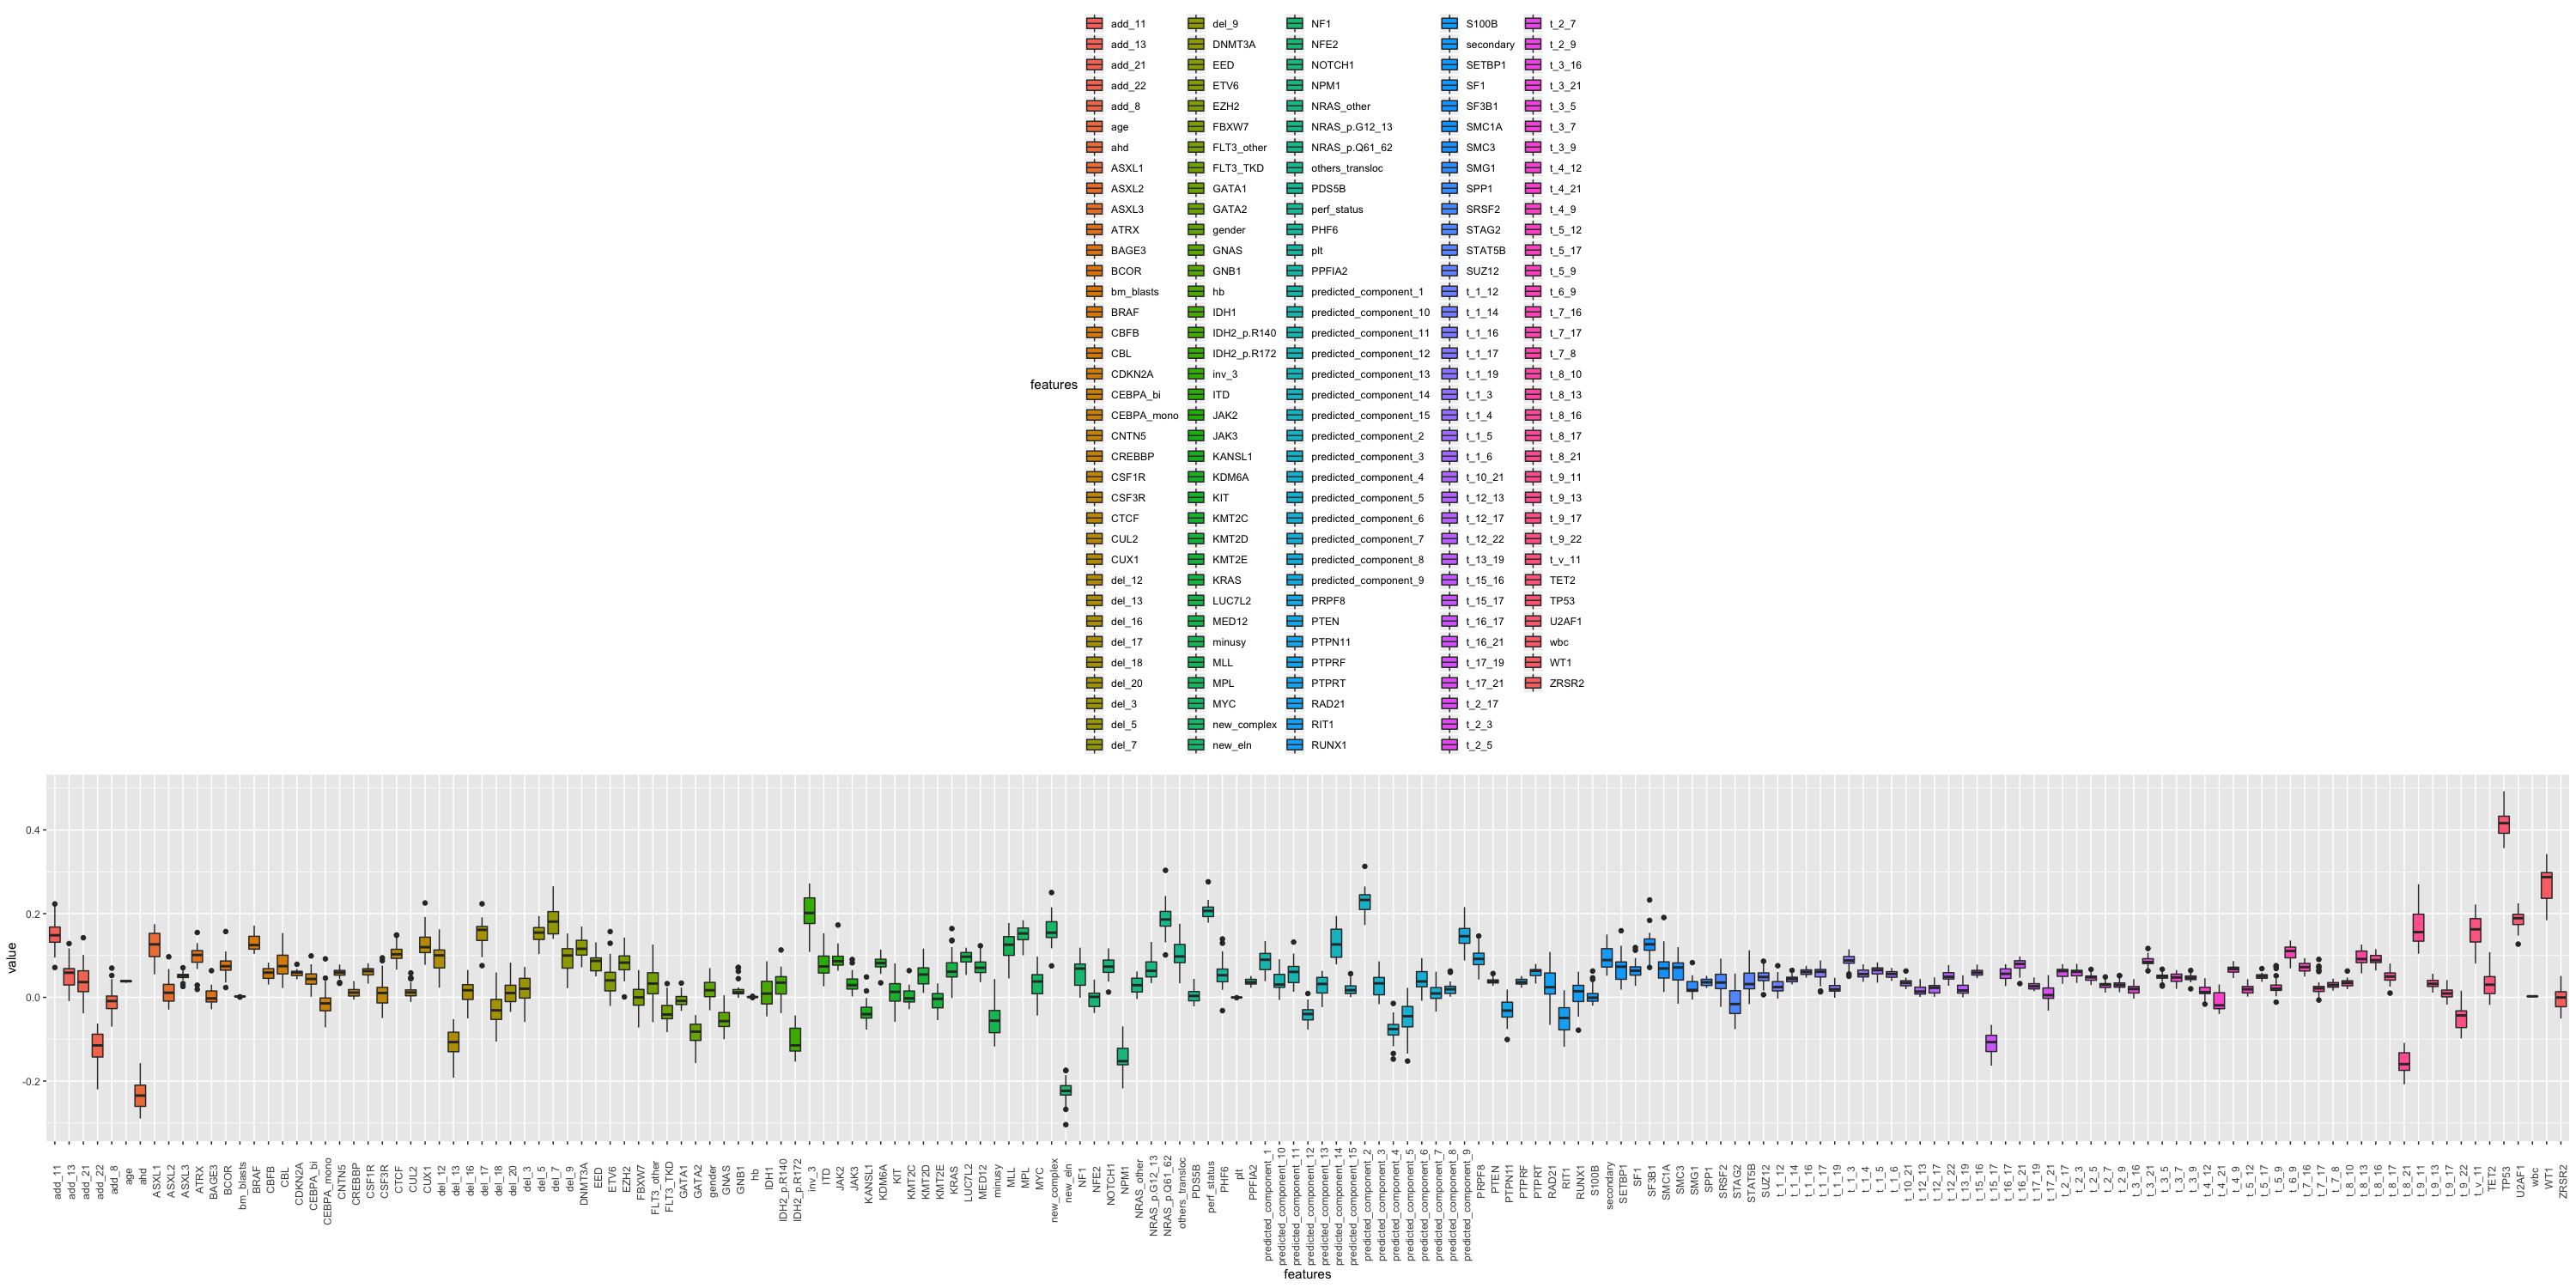

In [18]:
### rescv returns a list with 25 dataframes with the coefficient of each variables for the model cross validated fitted model and 25 concordance indices on the testings set used . We do the boxplots of the variable
### importance to have an exhaustive view over the same algorithm trained differently.
tmp <- rescv[[1]][[1]]
colnames(tmp)[1] <- "exp_1"
for (i in 2:length(rescv)){
    tmp <-cbind(tmp,rescv[[i]][[1]])
    colnames(tmp)[i] <- paste("exp",i,sep="_")
}
tmp <-as.data.frame(tmp)
tmp$median <- apply(tmp,1, median, na.rm = TRUE)
tmp$features <-rownames(tmp)
b <-melt(tmp,id='features')
colnames(b) <- c('features','exp','value')
set_notebook_plot_size(30,15)
ggplot(b,aes(x=features,y=value)) +
    geom_boxplot(aes(fill = features), notch=F)+
    #scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
    #facet_wrap( ~ model, ncol=2) +
    #geom_hline(data = model_medians, aes(yintercept = Z), linetype = 2)+
    theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))

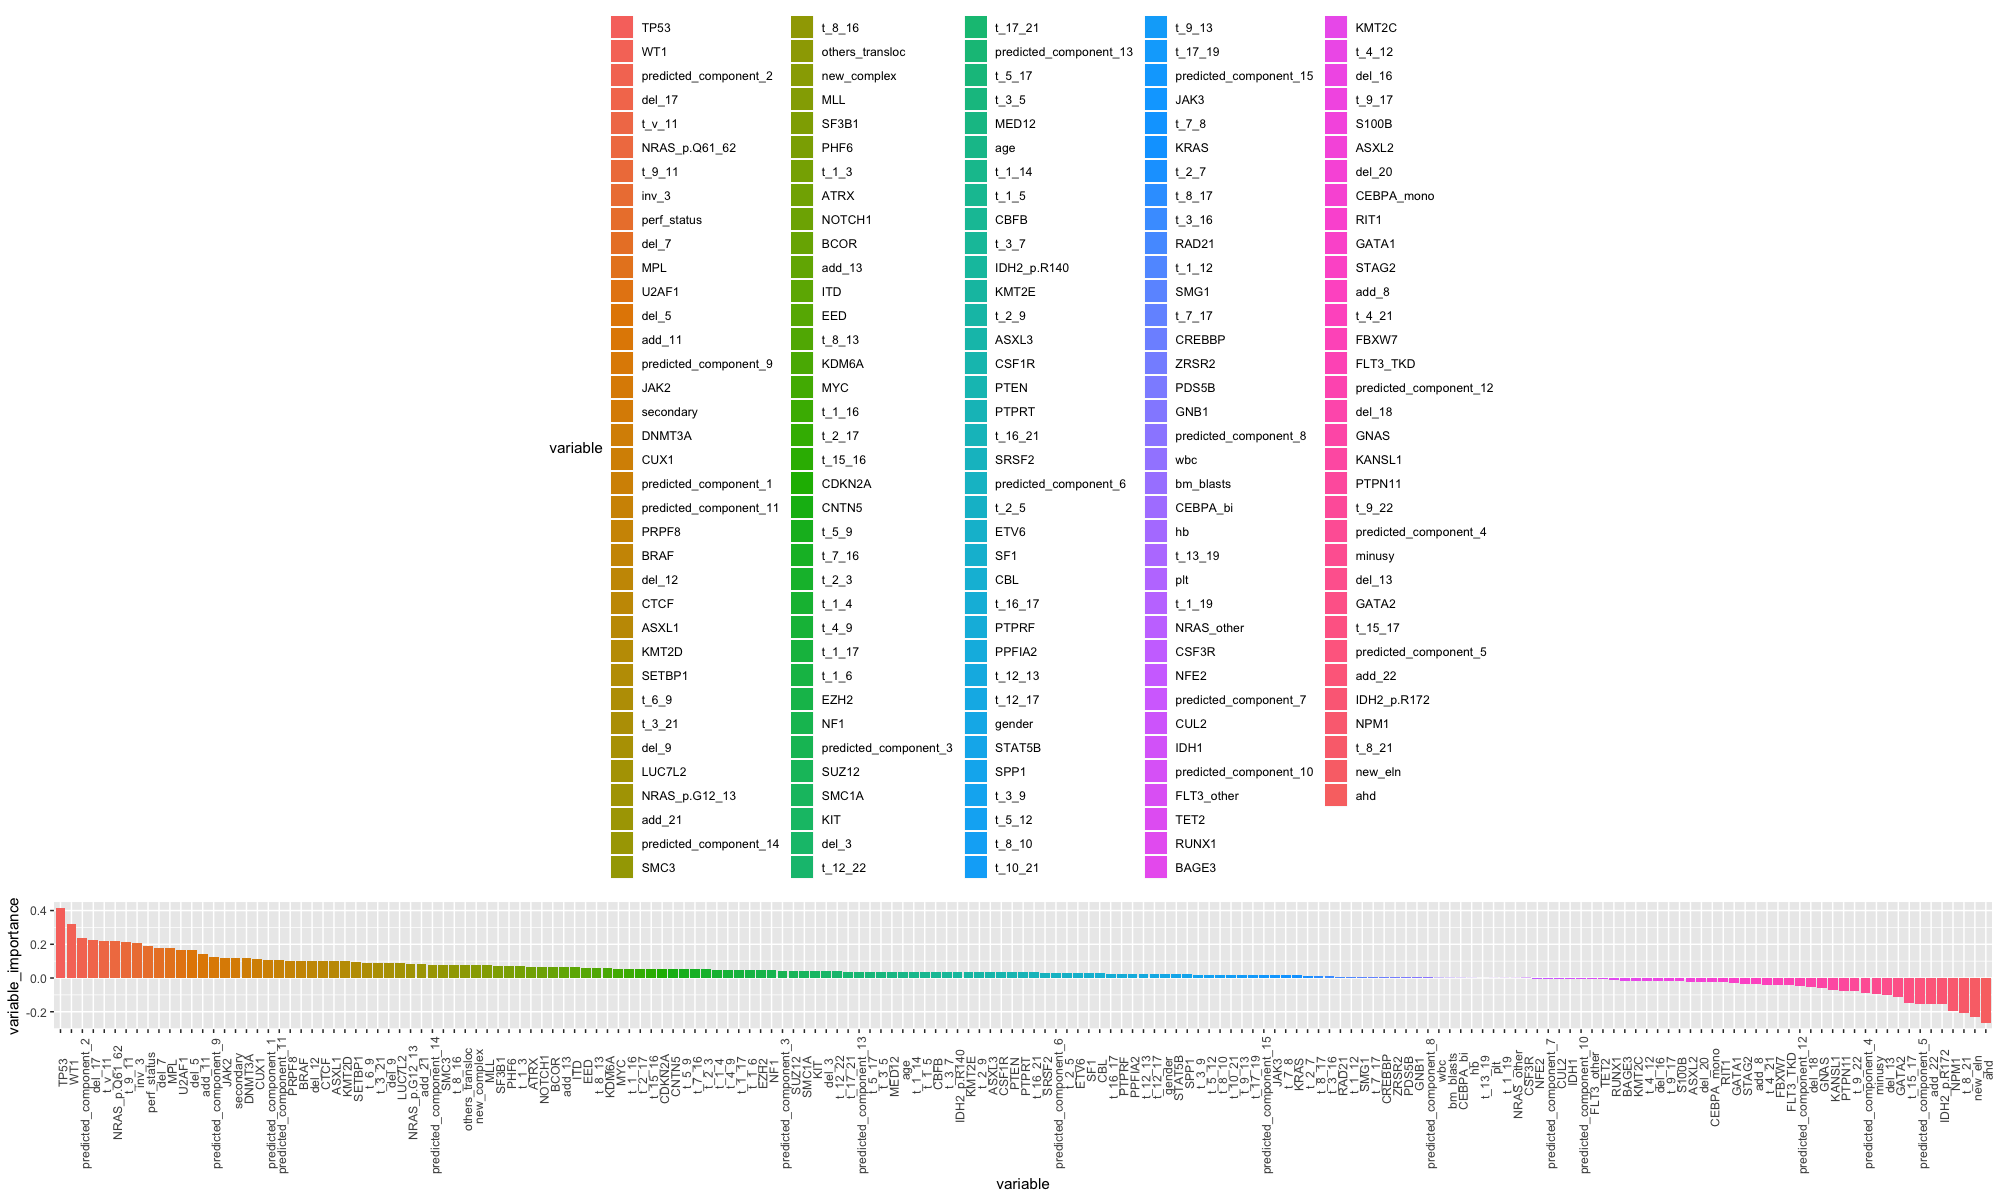

In [19]:
##Here, we look at the best concordance index that we got on testing set and we look at the coefficient that were obtained.
set_notebook_plot_size(20,12)
max_ci <-vector()
for (i in 1:length(rescv)){
    max_ci <- append(max_ci,rescv[[i]][[2]])
}
max = which(max_ci==max(max_ci))
l<- rescv[[max]][[1]]
l <- data.frame(l[l != 0,])
colnames(l) <- "variable_importance"
l$variable <-rownames(l)
l <- l[order(l$variable_importance,decreasing=T),]
l$variable <- factor(l$variable, levels = l$variable)

ggplot(l, aes(x=variable,y=variable_importance,fill=variable))+geom_bar(stat='identity')+
theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))